# Analisi del Rischio di Credito - Credit Scoring Model

In questa prima sezione, importo le librerie necessarie per la manipolazione dei dati, la visualizzazione e la modellazione. Successivamente, carichiamo il dataset `credit_scoring.csv` e verifichiamo che l'importazione sia avvenuta correttamente.

In [1]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv

--2026-02-04 06:49:46--  https://proai-datasets.s3.eu-west-3.amazonaws.com/credit_scoring.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 3.5.204.14, 3.5.205.38
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|3.5.204.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46985859 (45M) [text/csv]
Saving to: ‘credit_scoring.csv’

credit_scoring.csv  100%[===================>]  44.81M  14.5MB/s    in 3.1s    

2026-02-04 06:49:50 (14.5 MB/s) - ‘credit_scoring.csv’ saved [46985859/46985859]



In [2]:
# Sezione 1: Importazione dataset e librerie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time # Importa il modulo time per misurare i tempi di addestramento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

print("Librerie e dataset importati con successo.")

# Caricamento del dataset
try:
    df = pd.read_csv('credit_scoring.csv')
    print("Dataset 'credit_scoring.csv' caricato con successo.")
except FileNotFoundError:
    print("Errore: File non trovato. Assicurati di aver caricato 'credit_scoring.csv'.")

Librerie e dataset importati con successo.
Dataset 'credit_scoring.csv' caricato con successo.


## Analisi Esplorativa dei Dati (EDA) e Gestione Valori Mancanti

Qui analizziamo la struttura del dataset:
1.  Visualizziamo le prime righe e le statistiche descrittive.
2.  Controlliamo la distribuzione della variabile target (sbilanciamento delle classi).
3.  **Gestiamo i valori mancanti (Imputazione):** Usiamo la mediana per le variabili numeriche e la moda per quelle categoriche.

In [3]:
# Sezione 2: Analisi Esplorativa dei Dati (EDA)
print("\n--- Inizio Analisi Esplorativa dei Dati (EDA) ---")

# Ispezione iniziale dei dati
print("\nPrime 5 righe del DataFrame:")
print(df.head())
print("\nInformazioni sul DataFrame:")
df.info()
print("\nStatistiche descrittive:")
print(df.describe())
duplicate_rows = df.duplicated().sum()
print(f"\nNumero di righe duplicate: {duplicate_rows}")

# Distribuzione della variabile TARGET
print("\nDistribuzione della variabile TARGET:")
print(df['TARGET'].value_counts())
print("\nPercentuale di distribuzione della variabile TARGET:")
print(df['TARGET'].value_counts(normalize=True) * 100)

# Gestione dei valori mancanti
missing_values_cols = df.columns[df.isnull().any()].tolist()
print(f"\nColonne con valori mancanti: {missing_values_cols}")

numeric_cols_original = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols_original = df.select_dtypes(include=['object']).columns.tolist()

# Imputazione valori mancanti numerici con la mediana
for col in missing_values_cols:
    if col in numeric_cols_original:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Valori mancanti nella colonna numerica '{col}' imputati con la mediana: {median_val}")

# Imputazione valori mancanti categorici con la moda
for col in missing_values_cols:
    if col in categorical_cols_original:
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Valori mancanti nella colonna categorica '{col}' imputati con la moda: {mode_val}")

print("\nVerifica valori mancanti residui:")
print(df.isnull().sum())


--- Inizio Analisi Esplorativa dei Dati (EDA) ---

Prime 5 righe del DataFrame:
        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0         424380.57               Working               Higher education   
1         421593.52               Working               Higher education   
2         110958.51               Working  Secondary / secondary special   
3         267497.96  Commercial associate  Secondary / secondary special   
4         263419.09  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAY

## Feature Engineering

Trasformiamo alcune variabili per renderle più utili al modello:
* Convertiamo `DAYS_BIRTH` in `AGE_YEARS` (Età in anni).
* Convertiamo `DAYS_EMPLOYED` in `YEARS_EMPLOYED` e creiamo un flag `IS_UNEMPLOYED` per gestire le anomalie nei dati sull'impiego.

In [4]:
# Feature Engineering: Conversione DAYS_BIRTH e DAYS_EMPLOYED
df['AGE_YEARS'] = (-df['DAYS_BIRTH'] / 365.25).astype(int)
print("\nColonna 'AGE_YEARS' creata.")

df['YEARS_EMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: -x / 365.25 if x < 0 else 0).astype(int)
print("Colonna 'YEARS_EMPLOYED' creata.")

df['IS_UNEMPLOYED'] = df['DAYS_EMPLOYED'].apply(lambda x: 1 if x > 0 else 0)
print("Colonna 'IS_UNEMPLOYED' creata.")

df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'], inplace=True)
print("Colonne originali 'DAYS_BIRTH' e 'DAYS_EMPLOYED' eliminate.")


Colonna 'AGE_YEARS' creata.
Colonna 'YEARS_EMPLOYED' creata.
Colonna 'IS_UNEMPLOYED' creata.
Colonne originali 'DAYS_BIRTH' e 'DAYS_EMPLOYED' eliminate.


## Visualizzazione: Distribuzioni e Frequenze

Generiamo grafici per comprendere meglio i dati:
1.  **Istogrammi:** Per vedere la distribuzione delle variabili numeriche (es. reddito, età).
2.  **Count Plots:** Per vedere la frequenza delle categorie (es. livello di istruzione, stato civile).

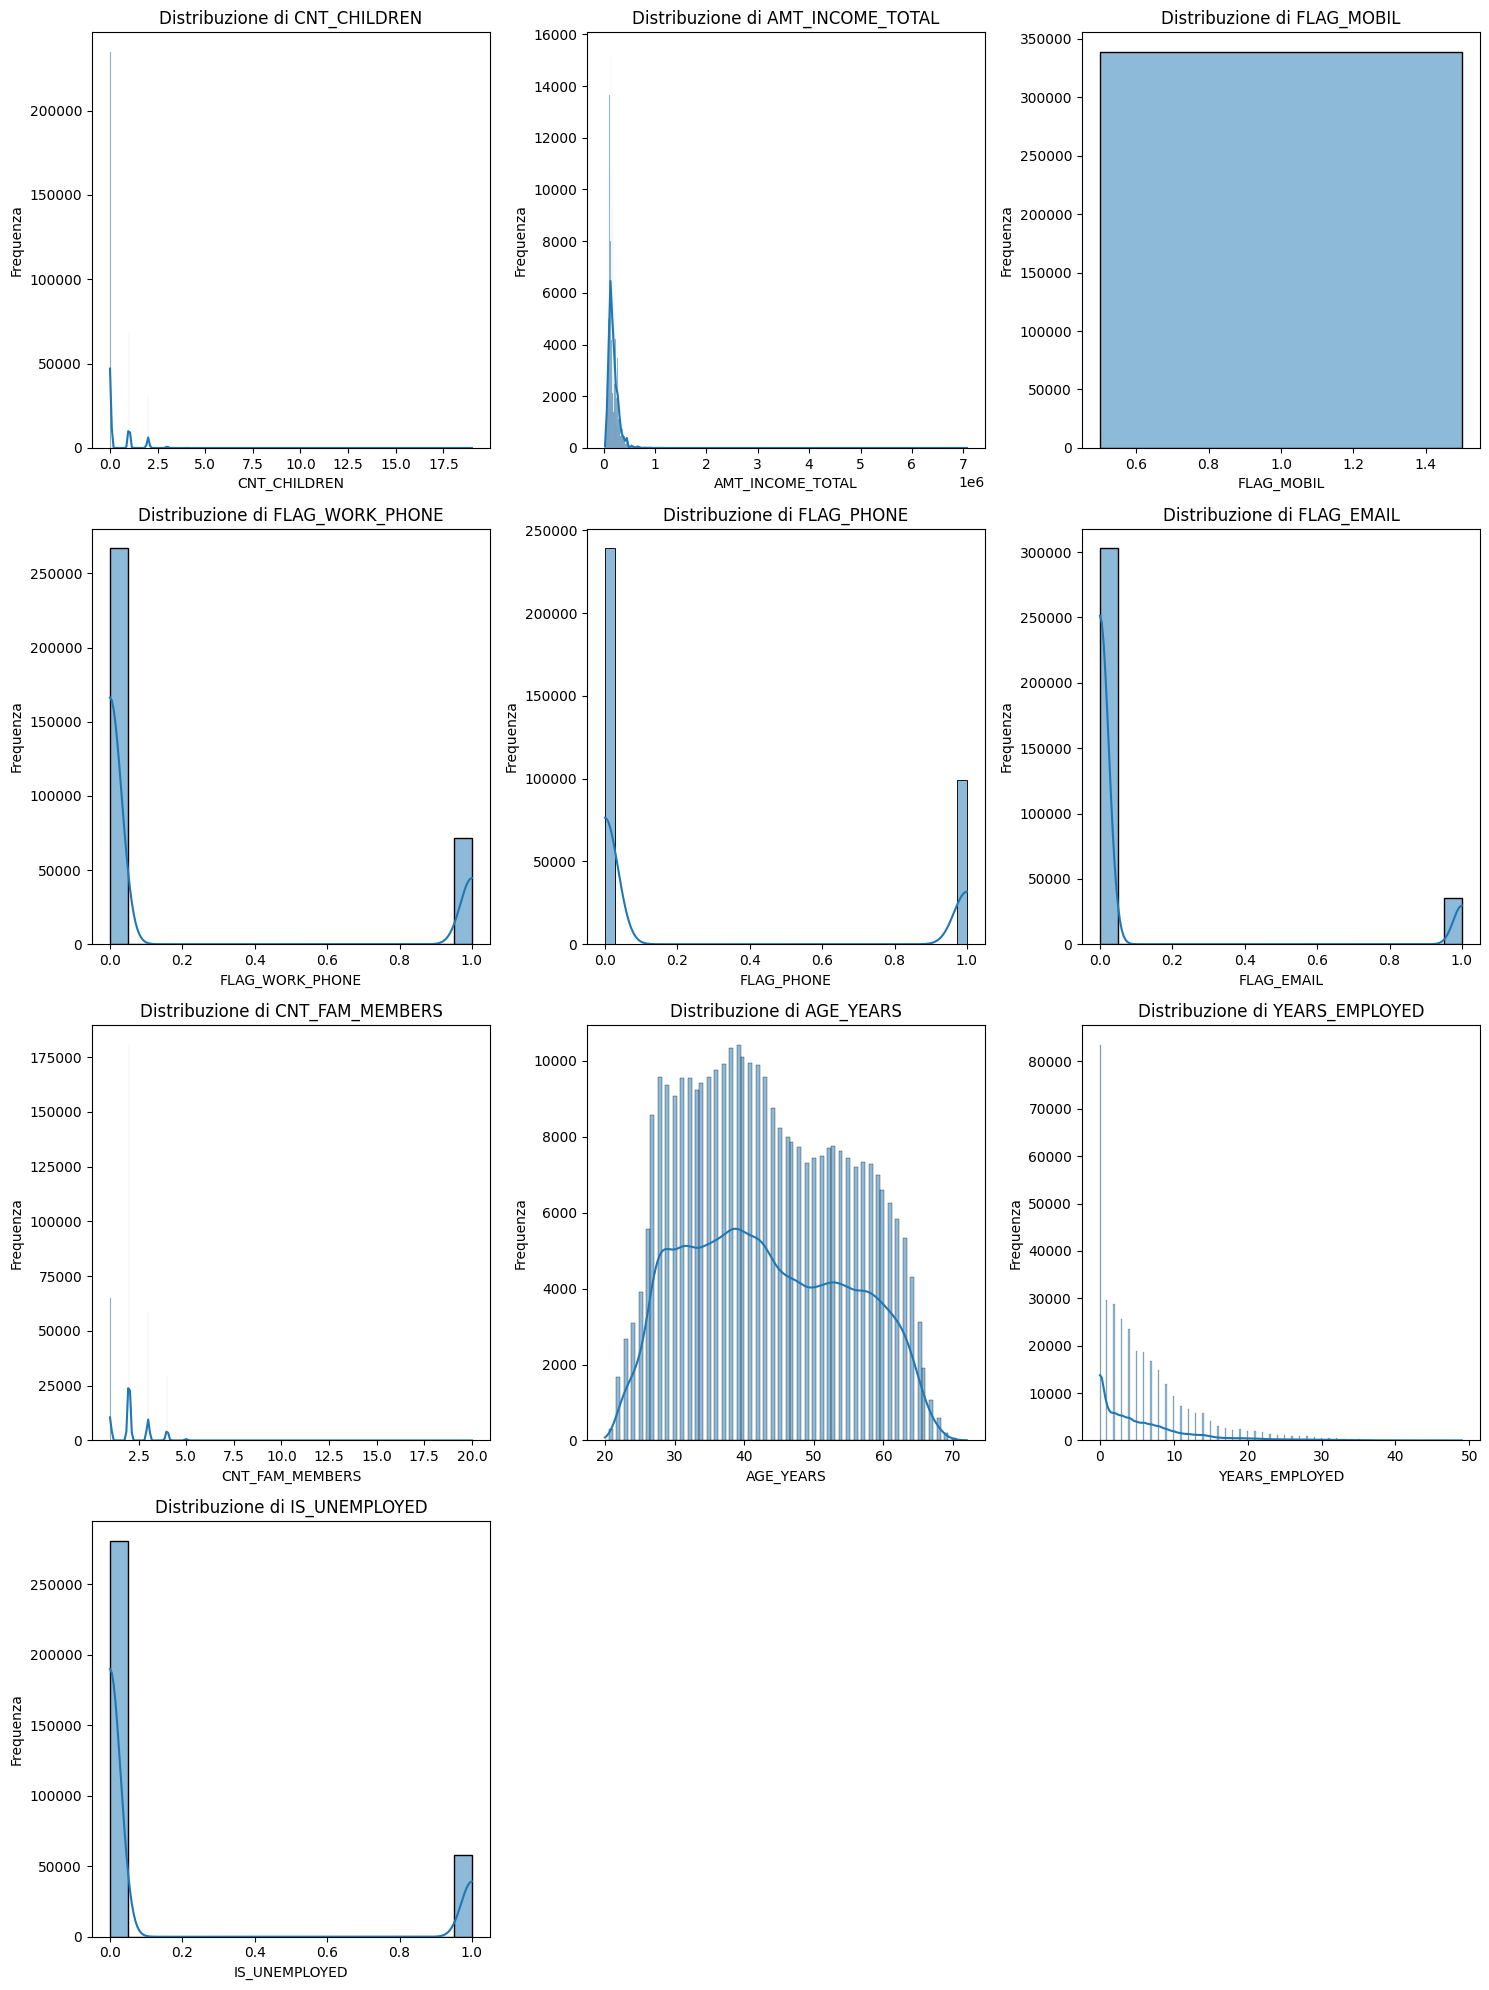

Istogrammi delle feature numeriche visualizzati.


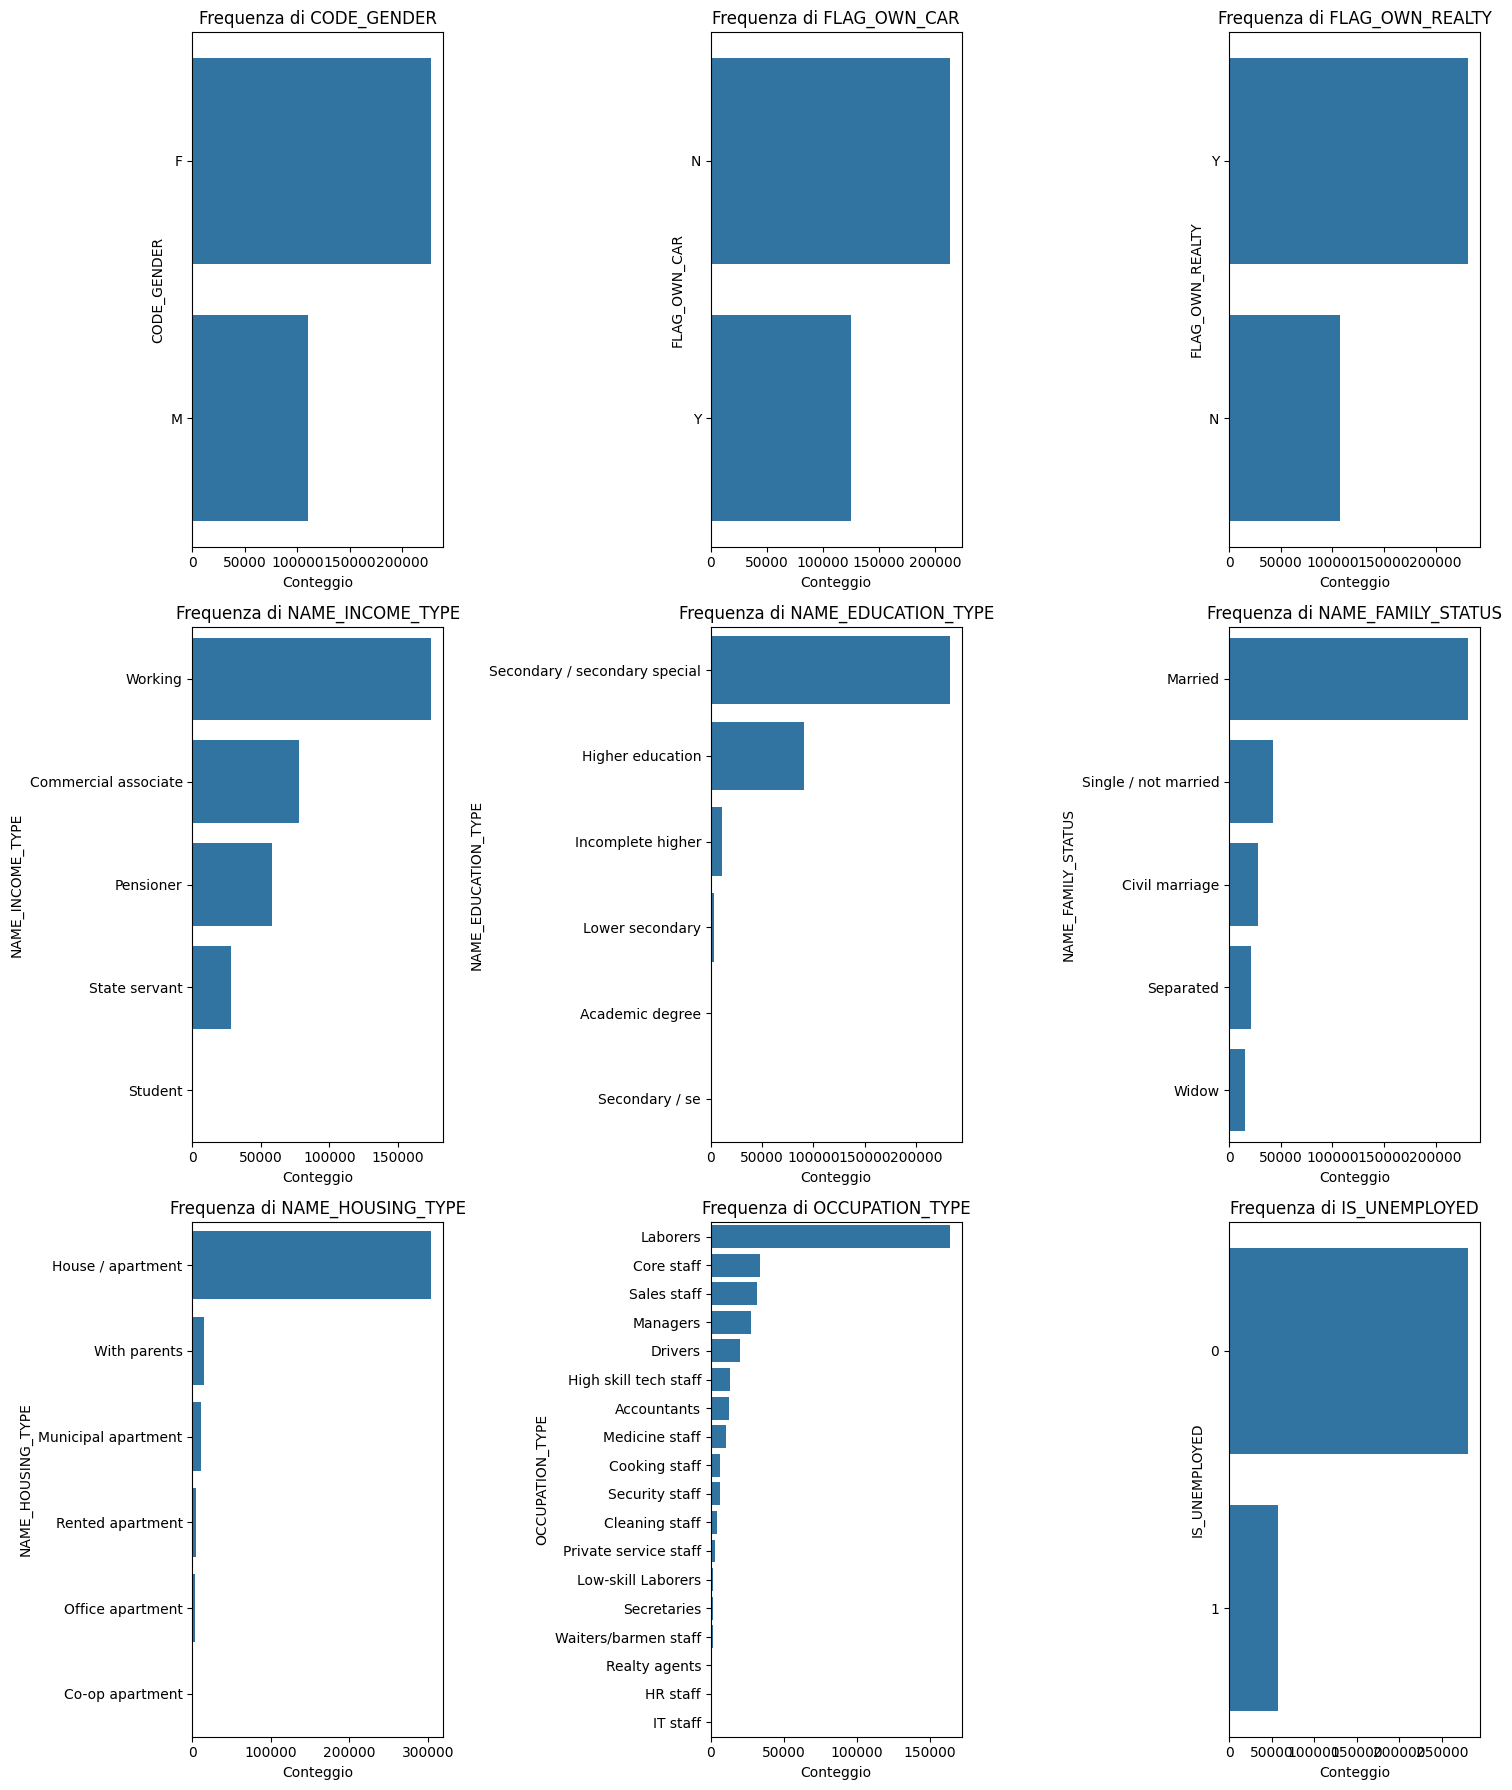

Count plots delle feature categoriche visualizzati.


In [5]:
# Visualizzazioni EDA
# I. Istogrammi per le feature numeriche
numeric_cols_for_hist = [col for col in df.select_dtypes(include=['number']).columns.tolist() if col not in ['ID', 'TARGET']]
num_plots = len(numeric_cols_for_hist)
cols_per_row = 3
rows = math.ceil(num_plots / cols_per_row)
plt.figure(figsize=(15, rows * 5))
for i, col in enumerate(numeric_cols_for_hist, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuzione di {col}')
    plt.xlabel(col)
    plt.ylabel('Frequenza')
plt.tight_layout()
plt.show()
print("Istogrammi delle feature numeriche visualizzati.")

# II. Count plots per le feature categoriche (inclusa IS_UNEMPLOYED)
categorical_cols_for_plot = df.select_dtypes(include=['object']).columns.tolist()
if 'IS_UNEMPLOYED' not in categorical_cols_for_plot:
    categorical_cols_for_plot.append('IS_UNEMPLOYED')
num_cat_plots = len(categorical_cols_for_plot)
cols_per_row_cat = 3
rows_cat = math.ceil(num_cat_plots / cols_per_row_cat)
plt.figure(figsize=(15, rows_cat * 6))
for i, col in enumerate(categorical_cols_for_plot, 1):
    plt.subplot(rows_cat, cols_per_row_cat, i)
    if col in df.columns:
        sns.countplot(data=df, y=col, order=df[col].value_counts().index)
        plt.title(f'Frequenza di {col}')
        plt.xlabel('Conteggio')
        plt.ylabel(col)
plt.tight_layout()
plt.show()
print("Count plots delle feature categoriche visualizzati.")

## Analisi Bivariata: Relazione con il Target

Analizziamo come le variabili influenzano la probabilità di default (`TARGET=1`):
* **Box Plots:** Per vedere se ci sono differenze nelle medie delle variabili numeriche tra chi paga e chi no.
* **Bar Plots:** Per vedere la percentuale di rischio per ogni categoria.

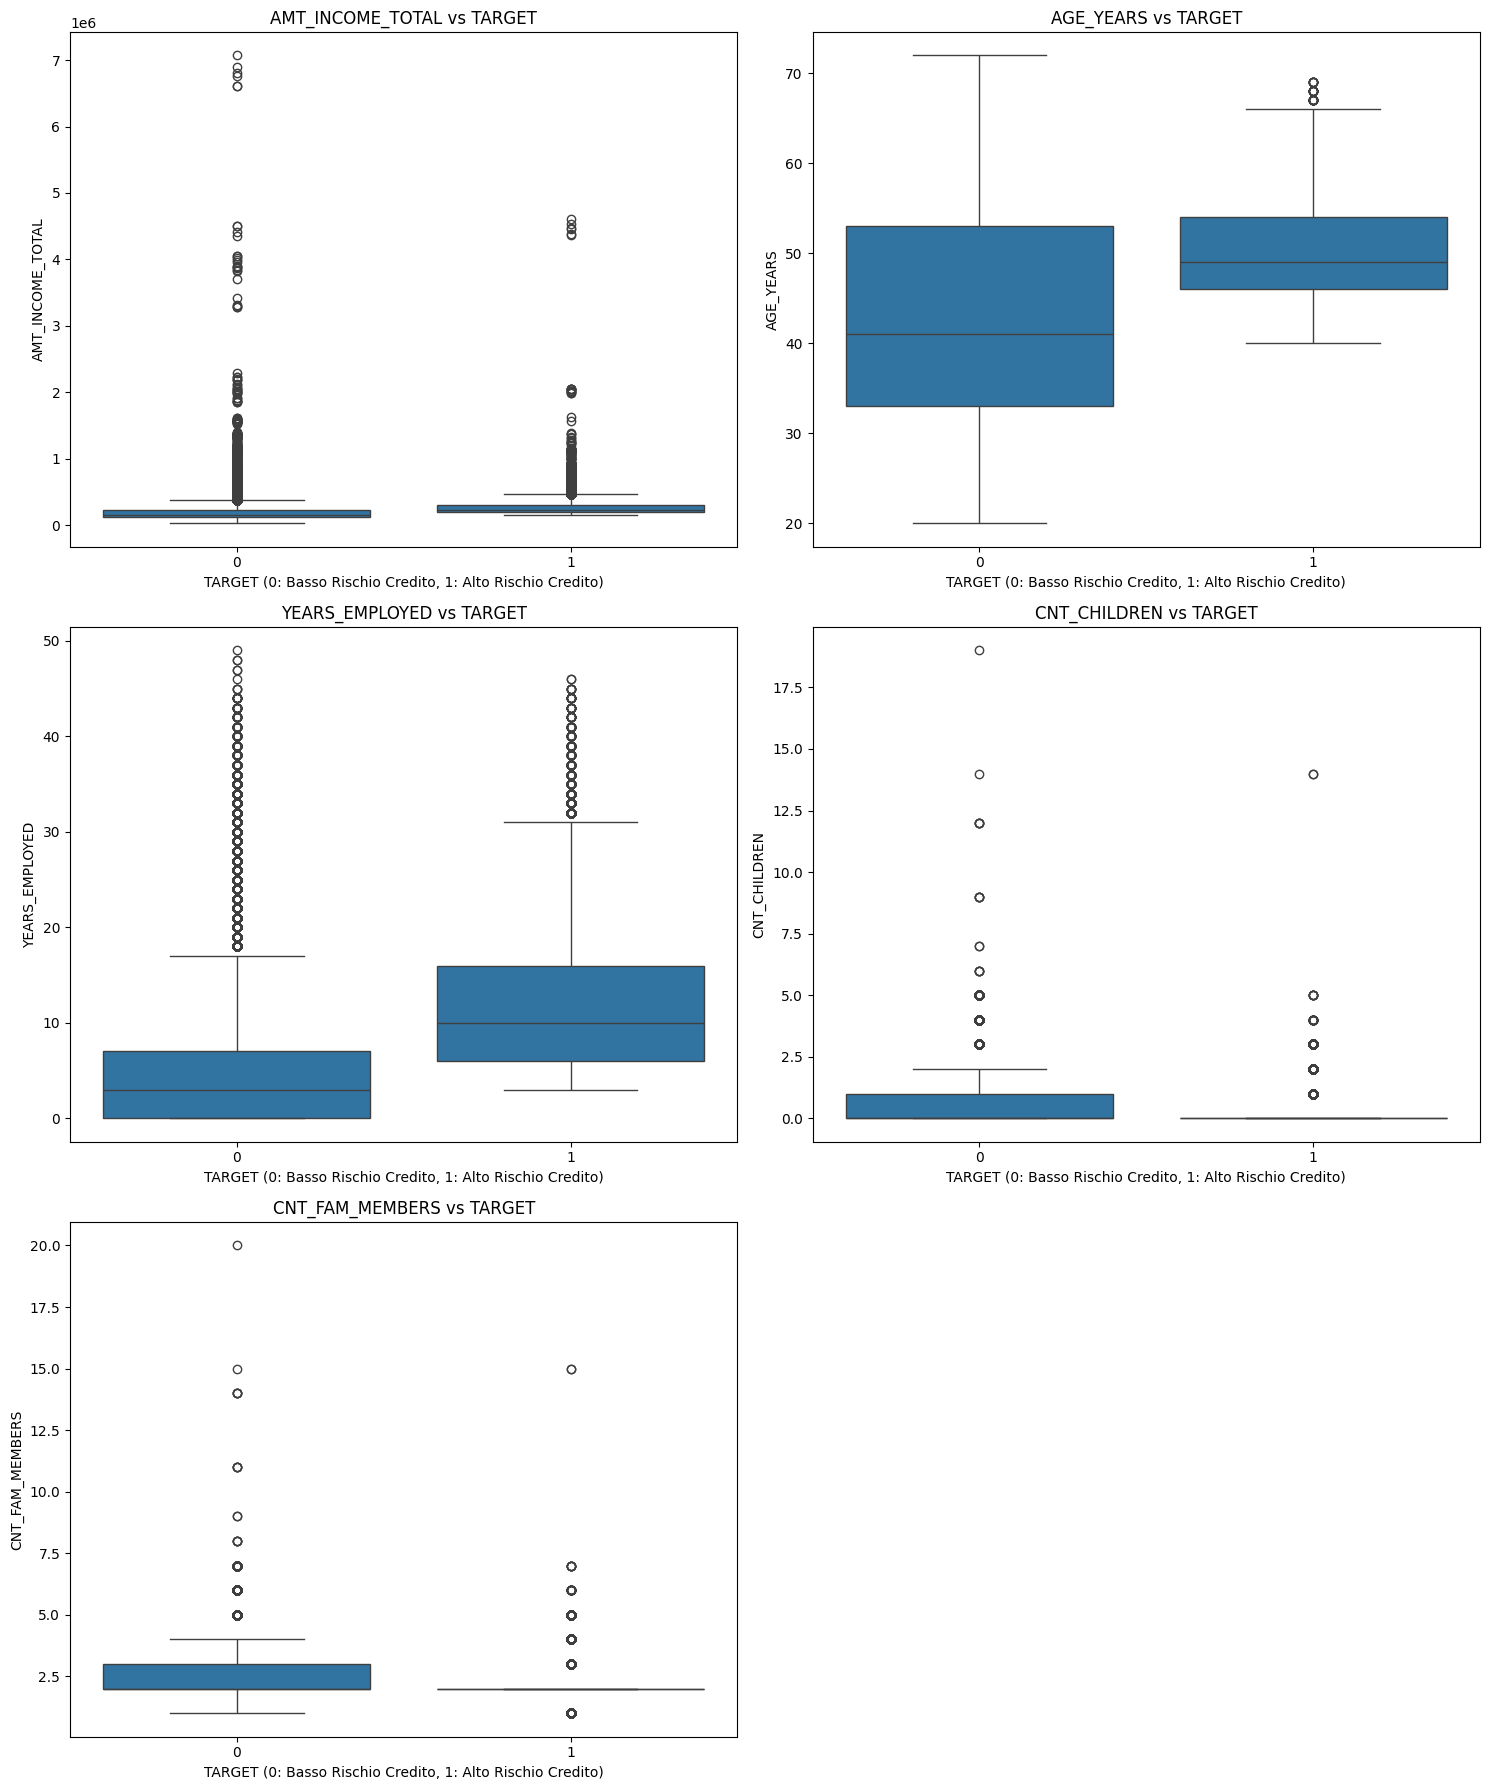

Box plots delle feature numeriche vs TARGET visualizzati.


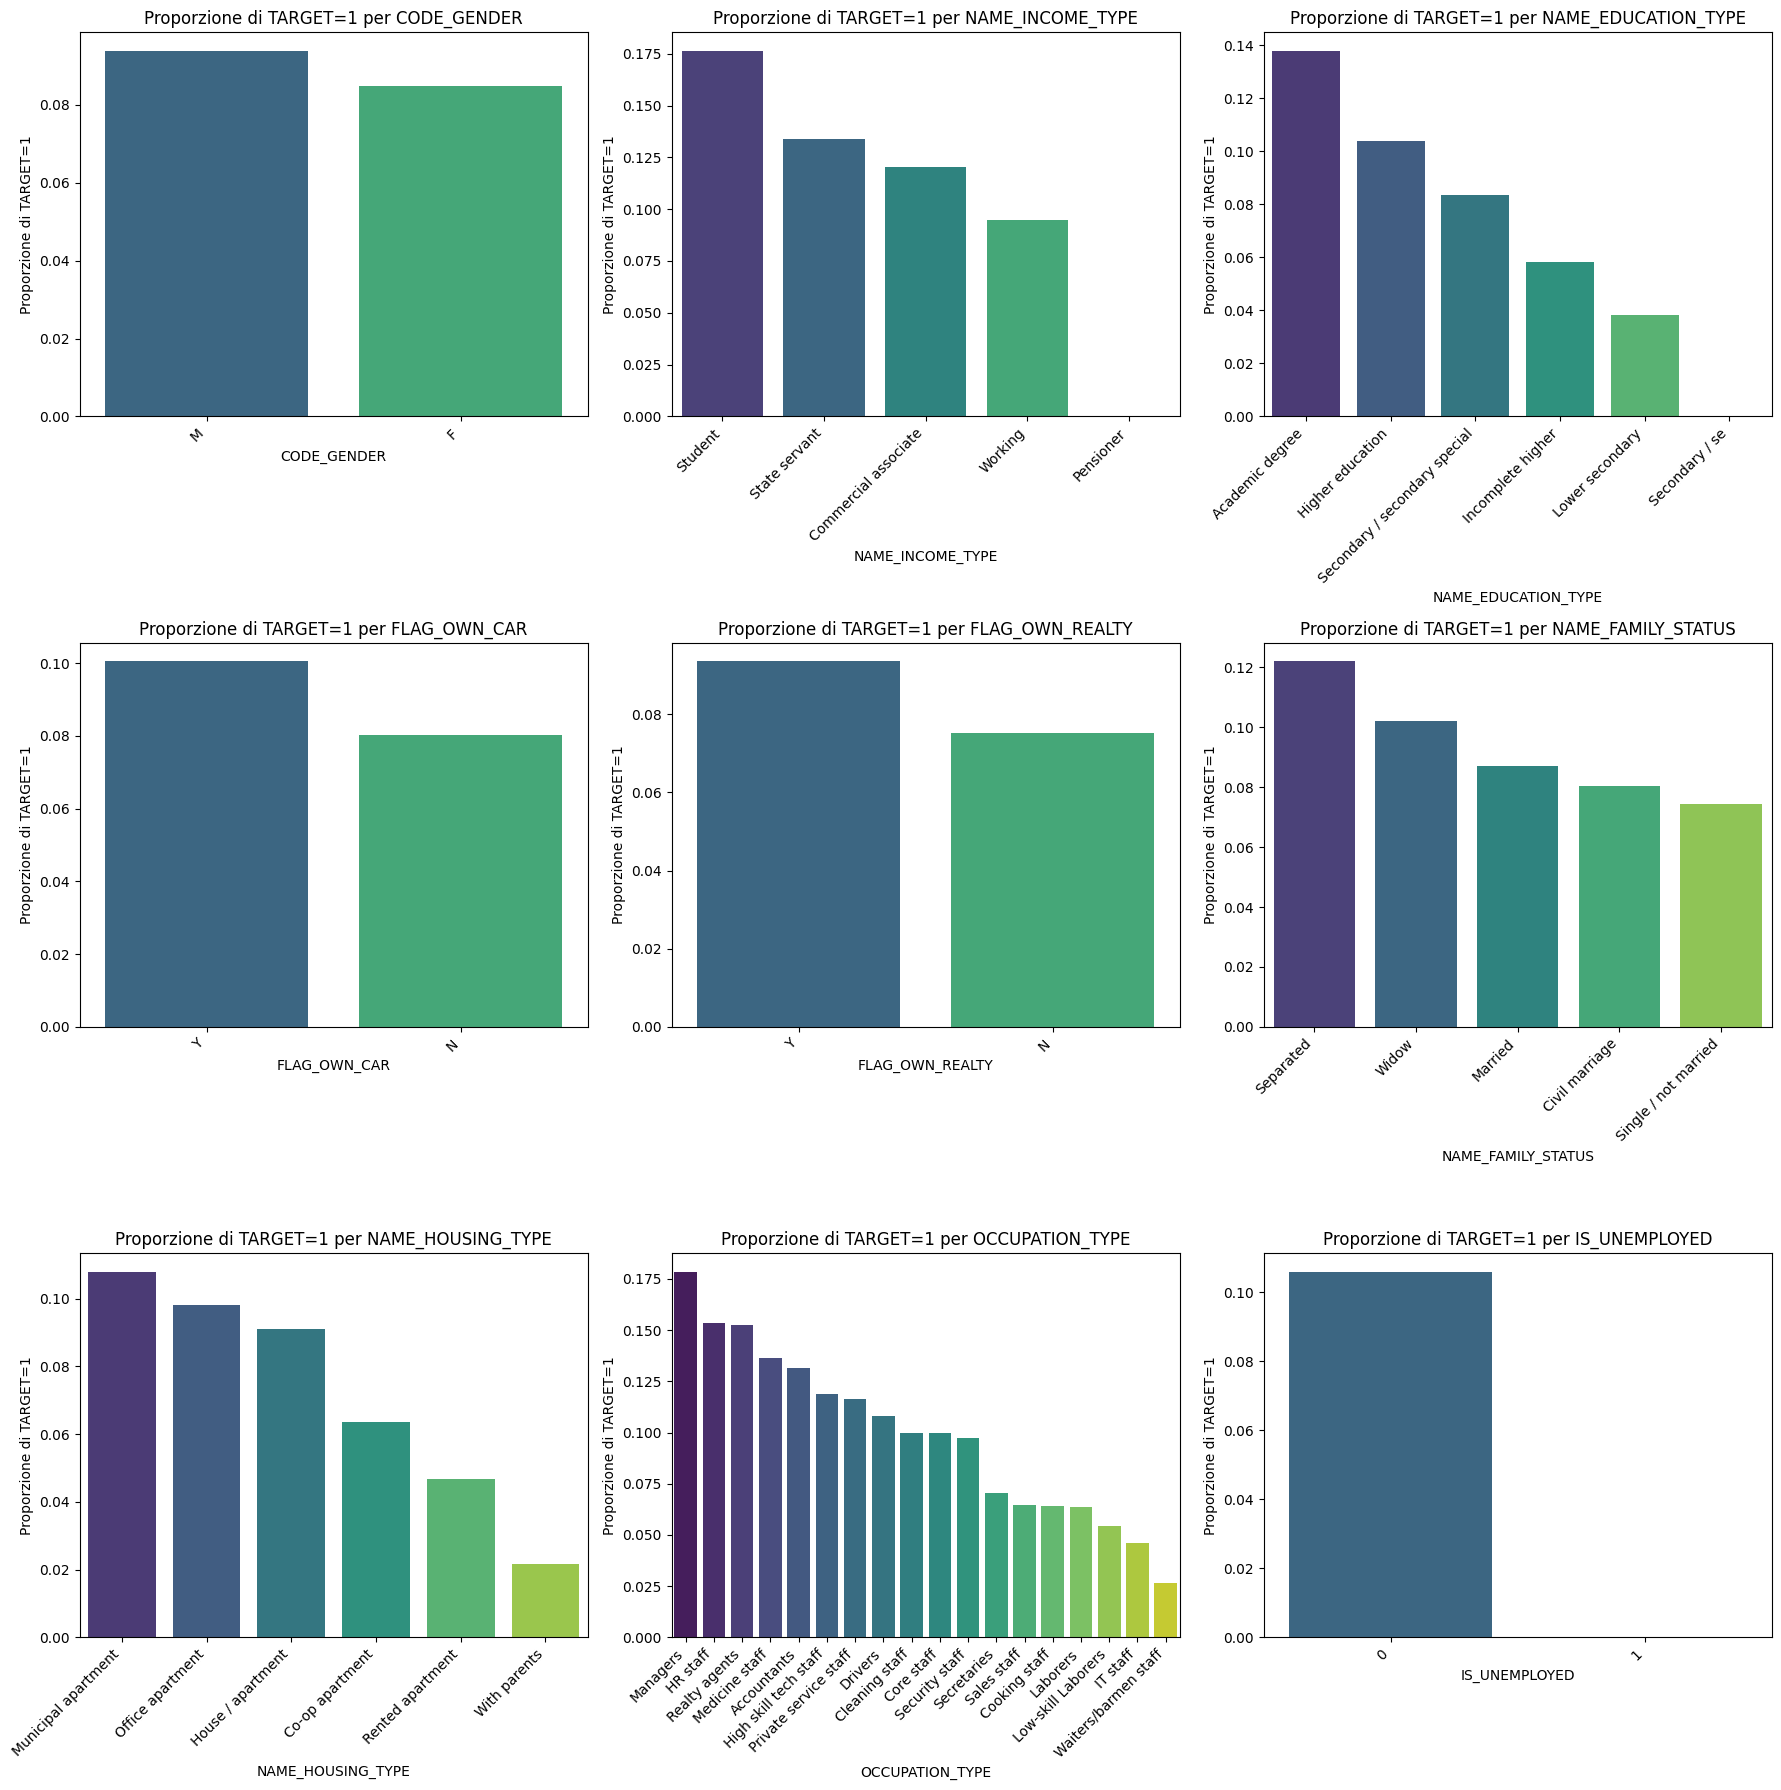

Bar plots delle feature categoriche vs TARGET visualizzati.
--- Fine Analisi Esplorativa dei Dati (EDA) ---


In [6]:
# III. Box plots delle feature numeriche vs TARGET
numeric_cols_for_boxplot = ['AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']
num_box_plots = len(numeric_cols_for_boxplot)
cols_per_row_box = 2
rows_box = math.ceil(num_box_plots / cols_per_row_box)
plt.figure(figsize=(15, rows_box * 6))
for i, col in enumerate(numeric_cols_for_boxplot, 1):
    plt.subplot(rows_box, cols_per_row_box, i)
    sns.boxplot(data=df, x='TARGET', y=col)
    plt.title(f'{col} vs TARGET')
    plt.xlabel('TARGET (0: Basso Rischio Credito, 1: Alto Rischio Credito)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()
print("Box plots delle feature numeriche vs TARGET visualizzati.")

# IV. Bar plots delle feature categoriche vs Proporzione di TARGET=1
categorical_cols_for_barplot = ['CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'IS_UNEMPLOYED']
num_bar_plots = len(categorical_cols_for_barplot)
cols_per_row_bar = 3
rows_bar = math.ceil(num_bar_plots / cols_per_row_bar)
plt.figure(figsize=(18, rows_bar * 6))
for i, col in enumerate(categorical_cols_for_barplot, 1):
    plt.subplot(rows_bar, cols_per_row_bar, i)
    target_proportion = df.groupby(col)['TARGET'].mean().sort_values(ascending=False).reset_index()
    sns.barplot(x=col, y='TARGET', data=target_proportion, palette='viridis', hue=col, legend=False)
    plt.title(f'Proporzione di TARGET=1 per {col}')
    plt.xlabel(col)
    plt.ylabel('Proporzione di TARGET=1')
    plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("Bar plots delle feature categoriche vs TARGET visualizzati.")
print("--- Fine Analisi Esplorativa dei Dati (EDA) ---")

## Matrice di Correlazione

Verifichiamo la collinearità tra le variabili numeriche. Una correlazione troppo alta tra due variabili indipendenti potrebbe creare problemi ad alcuni modelli (es. Regressione Logistica).


--- Inizio Matrice di Correlazione ---


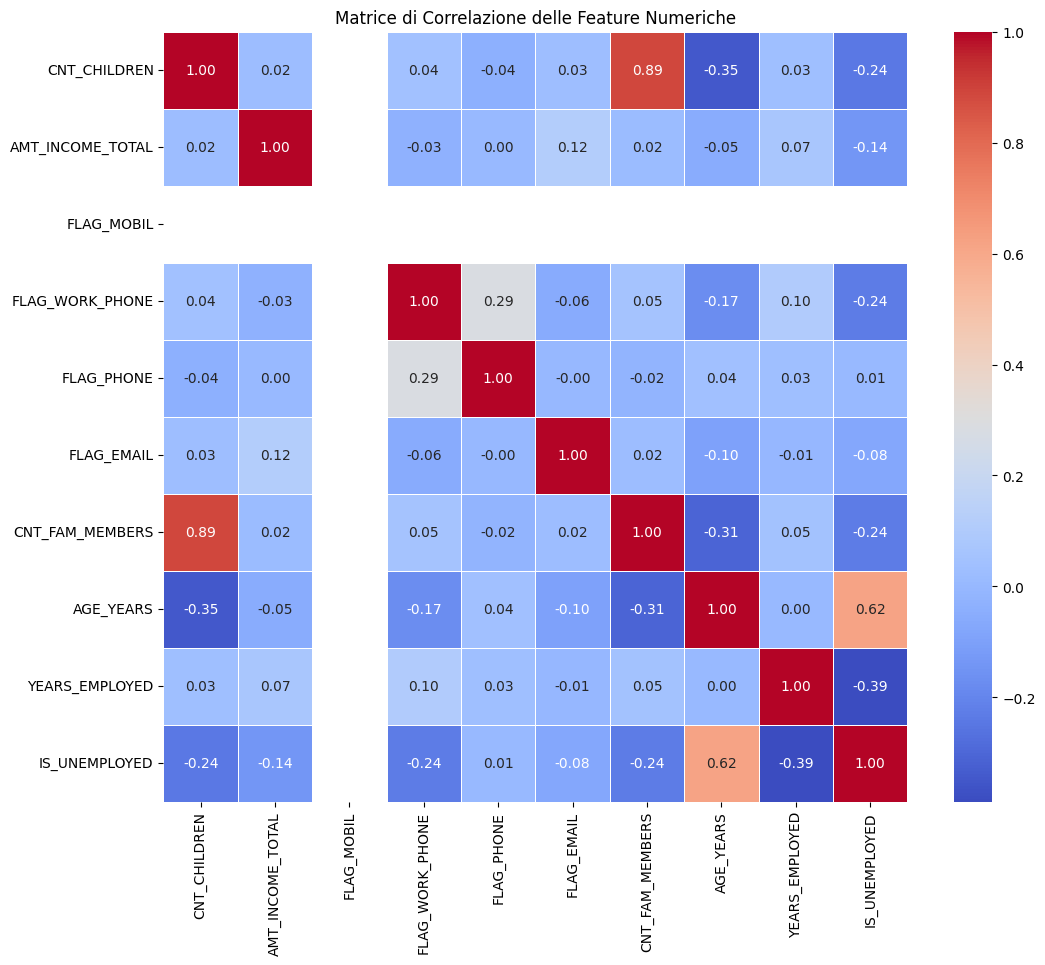

Matrice di correlazione calcolata e visualizzata con successo.
--- Fine Matrice di Correlazione ---


In [7]:
# Sezione 3: Matrice di Correlazione
print("\n--- Inizio Matrice di Correlazione ---")
# Identificazione delle feature numeriche per la correlazione (escludendo 'ID' e 'TARGET')
numerical_features_for_corr = [col for col in df.select_dtypes(include=['number']).columns.tolist() if col not in ['ID', 'TARGET']]

# Calcolo della matrice di correlazione
correlation_matrix = df[numerical_features_for_corr].corr()

# Visualizzazione della matrice di correlazione
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()
print("Matrice di correlazione calcolata e visualizzata con successo.")
print("--- Fine Matrice di Correlazione ---")

## Pre-processing dei Dati

Prima di addestrare i modelli:
1.  **One-Hot Encoding:** Trasformiamo le variabili categoriche (testo) in numeri (0 o 1).
2.  **Standard Scaling:** Normalizziamo le variabili numeriche affinché abbiano media 0 e deviazione standard 1 (fondamentale per la Regressione Logistica).
3.  **Train-Test Split:** Dividiamo i dati in 80% Training (per addestrare) e 20% Test (per valutare).

In [8]:
# Sezione 4: Encoding e Scaling
print("\n--- Inizio Pre-elaborazione (Encoding e Scaling) ---")
# Identificazione colonne categoriche e numeriche (escludendo 'ID' e 'TARGET')
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features_to_scale = [col for col in df.select_dtypes(include=['number']).columns.tolist() if col not in ['ID', 'TARGET']]

# One-Hot Encoding per le feature categoriche
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
print("One-Hot Encoding applicato alle feature categoriche.")

# Scaling delle feature numeriche con StandardScaler
scaler = StandardScaler()
df_encoded[numerical_features_to_scale] = scaler.fit_transform(df_encoded[numerical_features_to_scale])
print("Feature numeriche scalate con StandardScaler.")

# Sezione 5: Train-Test Split
# Separazione features (X) e target (y)
X = df_encoded.drop(columns=['ID', 'TARGET'])
y = df_encoded['TARGET']

# Divisione in set di training e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dataset diviso in training ({X_train.shape[0]} campioni) e test ({X_test.shape[0]} campioni).")


--- Inizio Pre-elaborazione (Encoding e Scaling) ---
One-Hot Encoding applicato alle feature categoriche.
Feature numeriche scalate con StandardScaler.
Dataset diviso in training (270741 campioni) e test (67686 campioni).


## 1. Regressione Logistica

Addestriamo il modello base. La Regressione Logistica è utile per la sua alta **interpretabilità** tramite i coefficienti.
* Analizziamo la *Confusion Matrix* per vedere quanti falsi positivi/negativi generiamo.
* Stampiamo i coefficienti per capire quali variabili aumentano o diminuiscono il rischio.


Addestramento Regressione Logistica...
Tempo di addestramento Regressione Logistica: 5.85 secondi

Metriche di valutazione Regressione Logistica:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90     61742
           1       0.32      0.89      0.47      5944

    accuracy                           0.82     67686
   macro avg       0.65      0.85      0.68     67686
weighted avg       0.93      0.82      0.86     67686

  Accuracy: 0.8249, Precision: 0.3201, Recall: 0.8851, F1-Score: 0.4702, ROC AUC: 0.9206


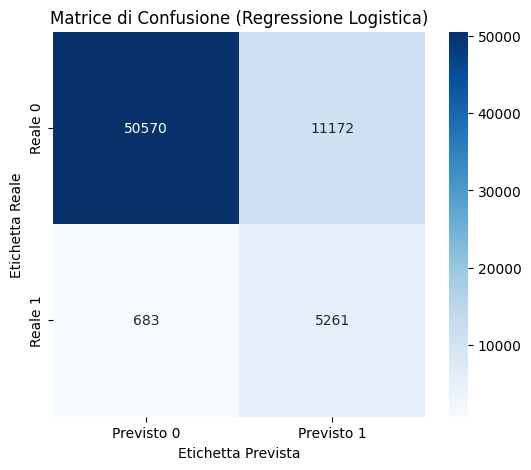


Top 10 coefficienti positivi (Regressione Logistica):
AGE_YEARS                                2.057638
AMT_INCOME_TOTAL                         1.074237
YEARS_EMPLOYED                           0.647296
NAME_INCOME_TYPE_Student                 0.564391
OCCUPATION_TYPE_HR staff                 0.530381
NAME_HOUSING_TYPE_Office apartment       0.230657
OCCUPATION_TYPE_Realty agents            0.184594
OCCUPATION_TYPE_Private service staff    0.163844
CODE_GENDER_M                            0.086084
NAME_FAMILY_STATUS_Separated             0.068807
dtype: float64

Top 10 coefficienti negativi (Regressione Logistica):
NAME_FAMILY_STATUS_Single / not married   -0.202926
OCCUPATION_TYPE_Low-skill Laborers        -0.286156
NAME_FAMILY_STATUS_Widow                  -0.339526
OCCUPATION_TYPE_Security staff            -0.352905
OCCUPATION_TYPE_Cooking staff             -0.397552
OCCUPATION_TYPE_Cleaning staff            -0.661357
OCCUPATION_TYPE_Waiters/barmen staff      -0.726968
OCCUPATION_

In [9]:
# --- Regressione Logistica ---
print("\nAddestramento Regressione Logistica...")
start_time = time.time()
model_lr = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear', max_iter=1000)
model_lr.fit(X_train, y_train)
end_time = time.time()
training_time_lr = end_time - start_time
print(f"Tempo di addestramento Regressione Logistica: {training_time_lr:.2f} secondi")
y_pred_lr = model_lr.predict(X_test)
y_pred_proba_lr = model_lr.predict_proba(X_test)[:, 1]

print("\nMetriche di valutazione Regressione Logistica:")
print(classification_report(y_test, y_pred_lr))
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
print(f"  Accuracy: {accuracy_lr:.4f}, Precision: {precision_lr:.4f}, Recall: {recall_lr:.4f}, F1-Score: {f1_lr:.4f}, ROC AUC: {roc_auc_lr:.4f}")

# Matrice di Confusione Regressione Logistica
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto 0', 'Previsto 1'], yticklabels=['Reale 0', 'Reale 1'])
plt.title('Matrice di Confusione (Regressione Logistica)')
plt.xlabel('Etichetta Prevista')
plt.ylabel('Etichetta Reale')
plt.show()

# Coefficienti Regressione Logistica per interpretabilità
coeff_df_lr = pd.Series(model_lr.coef_[0], index=X_train.columns).sort_values(ascending=False)
print("\nTop 10 coefficienti positivi (Regressione Logistica):")
print(coeff_df_lr.head(10))
print("\nTop 10 coefficienti negativi (Regressione Logistica):")
print(coeff_df_lr.tail(10))

## 2. Decision Tree

Utilizziamo un albero decisionale singolo.


[Image of decision tree structure]

* Questo modello non lineare può catturare relazioni più complesse.
* Visualizziamo la **Feature Importance** per capire quali variabili l'albero ritiene più utili per "tagliare" i dati.


Addestramento Decision Tree (Singolo Albero)...
Tempo di addestramento Decision Tree: 1.68 secondi

Metriche di valutazione Decision Tree:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     61742
           1       0.68      0.64      0.66      5944

    accuracy                           0.94     67686
   macro avg       0.82      0.81      0.81     67686
weighted avg       0.94      0.94      0.94     67686

  Accuracy: 0.9420, Precision: 0.6804, Recall: 0.6408, F1-Score: 0.6600, ROC AUC: 0.8059


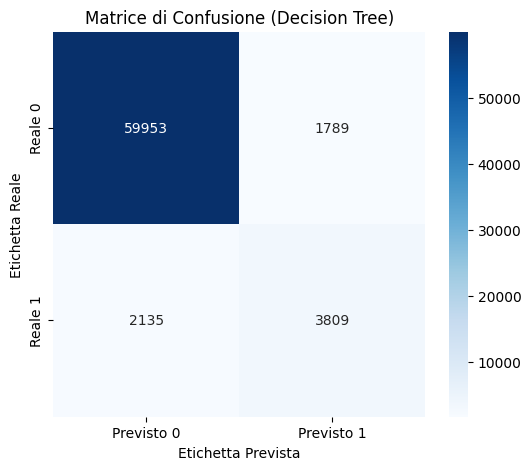


Top 20 Importanze Feature (Decision Tree):
AMT_INCOME_TOTAL                                     0.426373
AGE_YEARS                                            0.319874
YEARS_EMPLOYED                                       0.211770
CNT_FAM_MEMBERS                                      0.002791
NAME_INCOME_TYPE_Working                             0.002435
FLAG_OWN_REALTY_Y                                    0.002343
CODE_GENDER_M                                        0.002236
OCCUPATION_TYPE_Laborers                             0.001995
FLAG_EMAIL                                           0.001827
FLAG_PHONE                                           0.001793
FLAG_OWN_CAR_Y                                       0.001779
NAME_EDUCATION_TYPE_Secondary / secondary special    0.001584
NAME_INCOME_TYPE_State servant                       0.001532
FLAG_WORK_PHONE                                      0.001491
NAME_EDUCATION_TYPE_Higher education                 0.001447
OCCUPATION_TYPE_Managers  

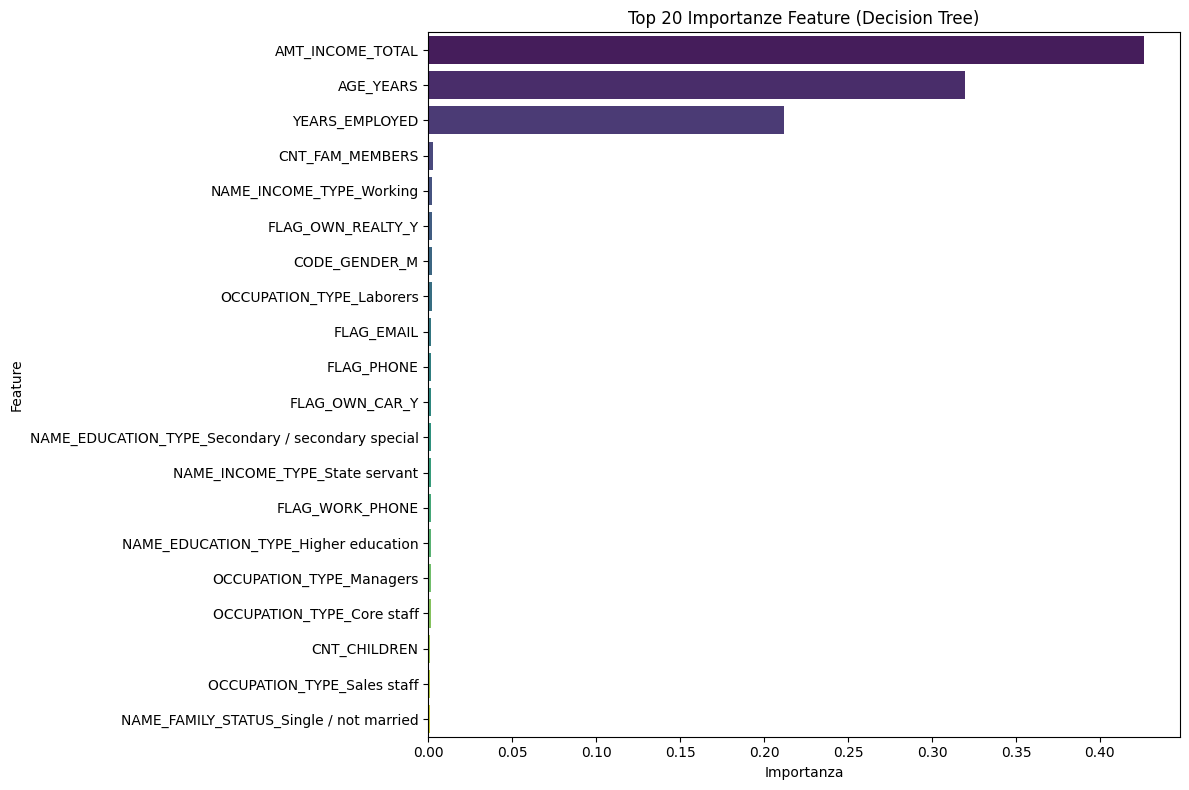

In [10]:
# --- Decision Tree --- (Modello Singolo)
print("\nAddestramento Decision Tree (Singolo Albero)...")
start_time = time.time()
dt_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt_model.fit(X_train, y_train)
end_time = time.time()
training_time_dt = end_time - start_time
print(f"Tempo di addestramento Decision Tree: {training_time_dt:.2f} secondi")
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

print("\nMetriche di valutazione Decision Tree:")
print(classification_report(y_test, y_pred_dt))
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print(f"  Accuracy: {accuracy_dt:.4f}, Precision: {precision_dt:.4f}, Recall: {recall_dt:.4f}, F1-Score: {f1_dt:.4f}, ROC AUC: {roc_auc_dt:.4f}")

# Matrice di Confusione Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto 0', 'Previsto 1'], yticklabels=['Reale 0', 'Reale 1'])
plt.title('Matrice di Confusione (Decision Tree)')
plt.xlabel('Etichetta Prevista')
plt.ylabel('Etichetta Reale')
plt.show()

# Importanza delle feature Decision Tree
feature_importances_dt = pd.Series(dt_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 20 Importanze Feature (Decision Tree):")
print(feature_importances_dt.head(20))
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_dt.head(20).values, y=feature_importances_dt.head(20).index, palette='viridis', hue=feature_importances_dt.head(20).index, legend=False)
plt.title('Top 20 Importanze Feature (Decision Tree)')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 3. Random Forest (Ensemble)

Il Random Forest unisce molti alberi decisionali per ridurre l'overfitting e migliorare la precisione.


[Image of random forest architecture]

* Eseguiamo un ciclo per testare diverse configurazioni di `n_estimators` (numero di alberi).
* Selezioniamo il modello migliore basandoci sull'F1-Score.


Addestramento Random Forest (Ensemble)...
  Addestramento Random Forest con n_estimators=50...
  Tempo di addestramento per n_estimators=50: 11.13 secondi
    F1-Score: 0.7053, ROC AUC Score: 0.9773
  Addestramento Random Forest con n_estimators=100...
  Tempo di addestramento per n_estimators=100: 22.01 secondi
    F1-Score: 0.7065, ROC AUC Score: 0.9779
  Addestramento Random Forest con n_estimators=200...
  Tempo di addestramento per n_estimators=200: 42.06 secondi
    F1-Score: 0.7078, ROC AUC Score: 0.9782

Miglior modello Random Forest trovato con n_estimators=200, F1-Score: 0.7078, ROC AUC: 0.9782.

Metriche di valutazione del miglior Random Forest:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     61742
           1       0.69      0.72      0.71      5944

    accuracy                           0.95     67686
   macro avg       0.83      0.85      0.84     67686
weighted avg       0.95      0.95      0.95     67686



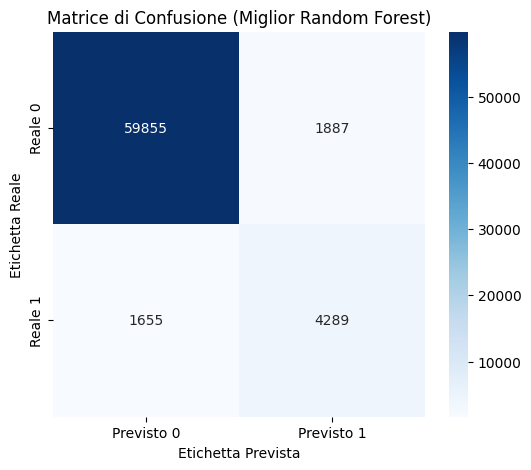


Top 20 Importanze Feature (Miglior Random Forest):
AMT_INCOME_TOTAL                                     0.315838
AGE_YEARS                                            0.292557
YEARS_EMPLOYED                                       0.248387
NAME_INCOME_TYPE_Pensioner                           0.031498
IS_UNEMPLOYED                                        0.023889
CNT_CHILDREN                                         0.013158
CNT_FAM_MEMBERS                                      0.011436
OCCUPATION_TYPE_Laborers                             0.005023
OCCUPATION_TYPE_Managers                             0.004421
NAME_INCOME_TYPE_Working                             0.004309
CODE_GENDER_M                                        0.003670
FLAG_OWN_CAR_Y                                       0.003550
FLAG_PHONE                                           0.003507
FLAG_OWN_REALTY_Y                                    0.003412
FLAG_WORK_PHONE                                      0.003398
NAME_HOUSING_TYPE_

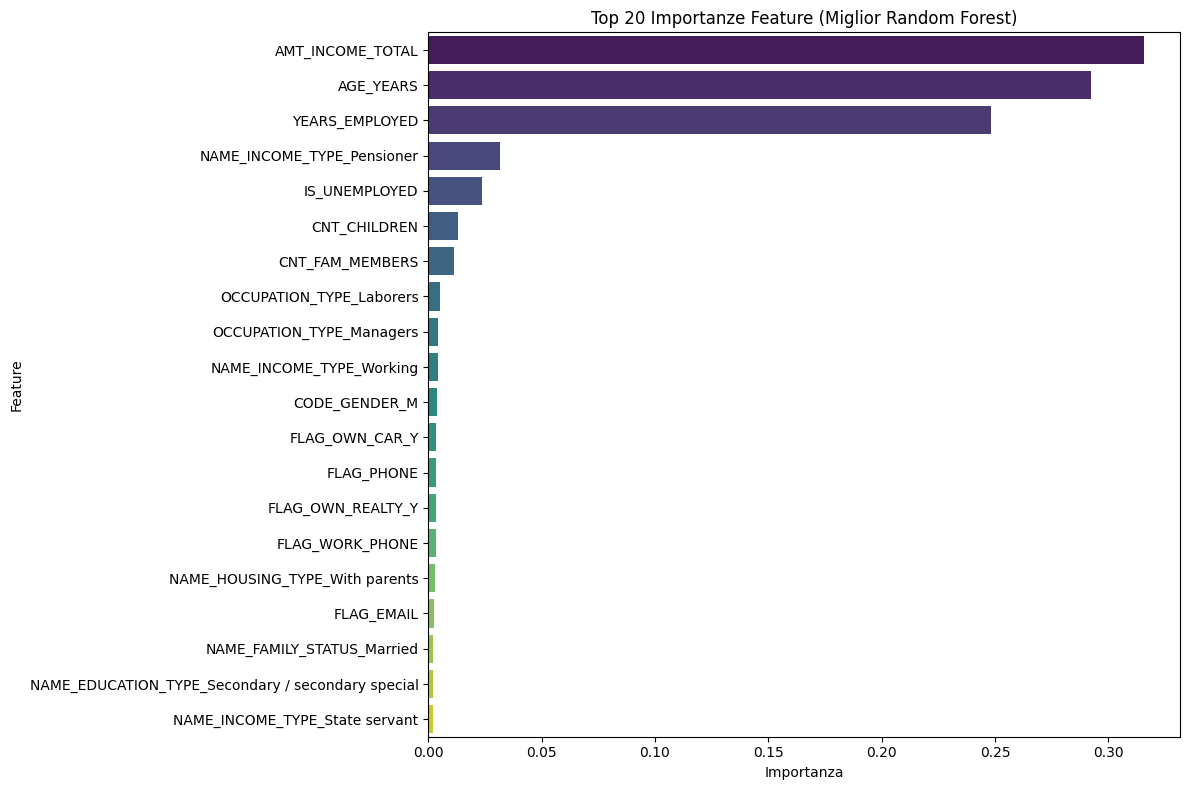

In [11]:
# --- Random Forest --- (Ensemble)
print("\nAddestramento Random Forest (Ensemble)...")
n_estimators_rf_configs = [50, 100, 200]
best_f1_rf = 0
best_roc_auc_rf = 0
best_model_rf = None
best_n_estimators_rf = None

for n_estimators in n_estimators_rf_configs:
    print(f"  Addestramento Random Forest con n_estimators={n_estimators}...")
    start_time = time.time()
    rf_model = RandomForestClassifier(n_estimators=n_estimators, class_weight='balanced', random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    end_time = time.time()
    training_time_rf_iter = end_time - start_time
    print(f"  Tempo di addestramento per n_estimators={n_estimators}: {training_time_rf_iter:.2f} secondi")

    y_pred_rf = rf_model.predict(X_test)
    y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    f1_rf = f1_score(y_test, y_pred_rf)
    roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
    print(f"    F1-Score: {f1_rf:.4f}, ROC AUC Score: {roc_auc_rf:.4f}")
    if f1_rf > best_f1_rf:
        best_f1_rf = f1_rf
        best_roc_auc_rf = roc_auc_rf
        best_model_rf = rf_model
        best_n_estimators_rf = n_estimators
print(f"\nMiglior modello Random Forest trovato con n_estimators={best_n_estimators_rf}, F1-Score: {best_f1_rf:.4f}, ROC AUC: {best_roc_auc_rf:.4f}.")

# Metriche del miglior Random Forest
y_pred_best_rf = best_model_rf.predict(X_test)
y_pred_proba_best_rf = best_model_rf.predict_proba(X_test)[:, 1]
print("\nMetriche di valutazione del miglior Random Forest:")
print(classification_report(y_test, y_pred_best_rf))

# Matrice di Confusione del miglior Random Forest
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Previsto 0', 'Previsto 1'], yticklabels=['Reale 0', 'Reale 1'])
plt.title('Matrice di Confusione (Miglior Random Forest)')
plt.xlabel('Etichetta Prevista')
plt.ylabel('Etichetta Reale')
plt.show()

# Importanza delle feature del miglior Random Forest
feature_importances_best_rf = pd.Series(best_model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\nTop 20 Importanze Feature (Miglior Random Forest):")
print(feature_importances_best_rf.head(20))
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_best_rf.head(20).values, y=feature_importances_best_rf.head(20).index, palette='viridis', hue=feature_importances_best_rf.head(20).index, legend=False)
plt.title('Top 20 Importanze Feature (Miglior Random Forest)')
plt.xlabel('Importanza')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 4. Bagging (Bootstrap Aggregating)

Testiamo la tecnica di Bagging applicata sia alla Regressione Logistica che agli Alberi Decisionali. Questa tecnica crea sottoinsiemi casuali del dataset per addestrare modelli diversi e farne la media.

In [12]:
# --- Bagging con Regressione Logistica ---
print("\nAddestramento Bagging con Regressione Logistica...")
n_estimators_bagging = [50, 100, 150, 200]
max_features_bagging = 7
max_samples_ratios = [0.2, 0.4, 0.6]
num_training_samples = X_train.shape[0]
max_samples_absolute = [int(ratio * num_training_samples) for ratio in max_samples_ratios]

best_f1_bagging_lr = 0
best_roc_auc_bagging_lr = 0
best_bagging_lr_model = None
best_lr_bagging_n_estimators = None
best_lr_bagging_max_samples = None

for n_estimators in n_estimators_bagging:
    for max_samples in max_samples_absolute:
        # Nota: print rimosso nel loop per pulizia output, de-commentare se necessario
        base_lr = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear', max_iter=1000)
        bagging_lr_model = BaggingClassifier(
            estimator=base_lr,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features_bagging,
            bootstrap=True,
            n_jobs=-1,
            random_state=42
        )
        bagging_lr_model.fit(X_train, y_train)

        y_pred_bagging_lr = bagging_lr_model.predict(X_test)
        y_pred_proba_bagging_lr = bagging_lr_model.predict_proba(X_test)[:, 1]
        f1_bagging_lr = f1_score(y_test, y_pred_bagging_lr)
        roc_auc_bagging_lr = roc_auc_score(y_test, y_pred_proba_bagging_lr)

        if f1_bagging_lr > best_f1_bagging_lr:
            best_f1_bagging_lr = f1_bagging_lr
            best_roc_auc_bagging_lr = roc_auc_bagging_lr
            best_bagging_lr_model = bagging_lr_model
            best_lr_bagging_n_estimators = n_estimators
            best_lr_bagging_max_samples = max_samples

print(f"\nMiglior modello Bagging con LR: n_estimators={best_lr_bagging_n_estimators}, max_samples={best_lr_bagging_max_samples}, F1: {best_f1_bagging_lr:.4f}, ROC AUC: {best_roc_auc_bagging_lr:.4f}.")

# --- Bagging con Decision Tree ---
print("\nAddestramento Bagging con Decision Tree...")
best_f1_bagging_dt = 0
best_roc_auc_bagging_dt = 0
best_bagging_dt_model = None
best_dt_bagging_n_estimators = None
best_dt_bagging_max_samples = None

for n_estimators in n_estimators_bagging:
    for max_samples in max_samples_absolute:
        base_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
        bagging_dt_model = BaggingClassifier(
            estimator=base_dt,
            n_estimators=n_estimators,
            max_samples=max_samples,
            max_features=max_features_bagging,
            bootstrap=True,
            n_jobs=-1,
            random_state=42
        )
        bagging_dt_model.fit(X_train, y_train)

        y_pred_bagging_dt = bagging_dt_model.predict(X_test)
        y_pred_proba_bagging_dt = bagging_dt_model.predict_proba(X_test)[:, 1]
        f1_bagging_dt = f1_score(y_test, y_pred_bagging_dt)
        roc_auc_bagging_dt = roc_auc_score(y_test, y_pred_proba_bagging_dt)

        if f1_bagging_dt > best_f1_bagging_dt:
            best_f1_bagging_dt = f1_bagging_dt
            best_roc_auc_bagging_dt = roc_auc_bagging_dt
            best_bagging_dt_model = bagging_dt_model
            best_dt_bagging_n_estimators = n_estimators
            best_dt_bagging_max_samples = max_samples

print(f"\nMiglior modello Bagging con DT: n_estimators={best_dt_bagging_n_estimators}, max_samples={best_dt_bagging_max_samples}, F1: {best_f1_bagging_dt:.4f}, ROC AUC: {best_roc_auc_bagging_dt:.4f}.")


Addestramento Bagging con Regressione Logistica...

Miglior modello Bagging con LR: n_estimators=150, max_samples=54148, F1: 0.4181, ROC AUC: 0.8998.

Addestramento Bagging con Decision Tree...

Miglior modello Bagging con DT: n_estimators=150, max_samples=54148, F1: 0.6018, ROC AUC: 0.9485.


## Confronto Finale e Scelta del Modello

Confrontiamo le metriche di tutti i modelli in una tabella riassuntiva.
Visualizziamo inoltre la struttura di un singolo albero decisionale per finalità di interpretabilità.


--- Inizio Scelta e Uso del Miglior Modello ---

Confronto delle Metriche di Performance di tutti i Modelli:
                          Accuracy  Precision  Recall  F1-Score  ROC AUC
Regressione Logistica       0.8249     0.3201  0.8851    0.4702   0.9206
Decision Tree               0.9420     0.6804  0.6408    0.6600   0.8059
Random Forest (Migliore)    0.9477     0.6945  0.7216    0.7078   0.9782
Bagging LR (Migliore)       0.7867     0.2749  0.8725    0.4181   0.8998
Bagging DT (Migliore)       0.9062     0.4796  0.8075    0.6018   0.9485

Il modello Random Forest (Migliore) è stato scelto come il più adatto per le sue prestazioni predittive superiori in termini di F1-Score e ROC AUC.


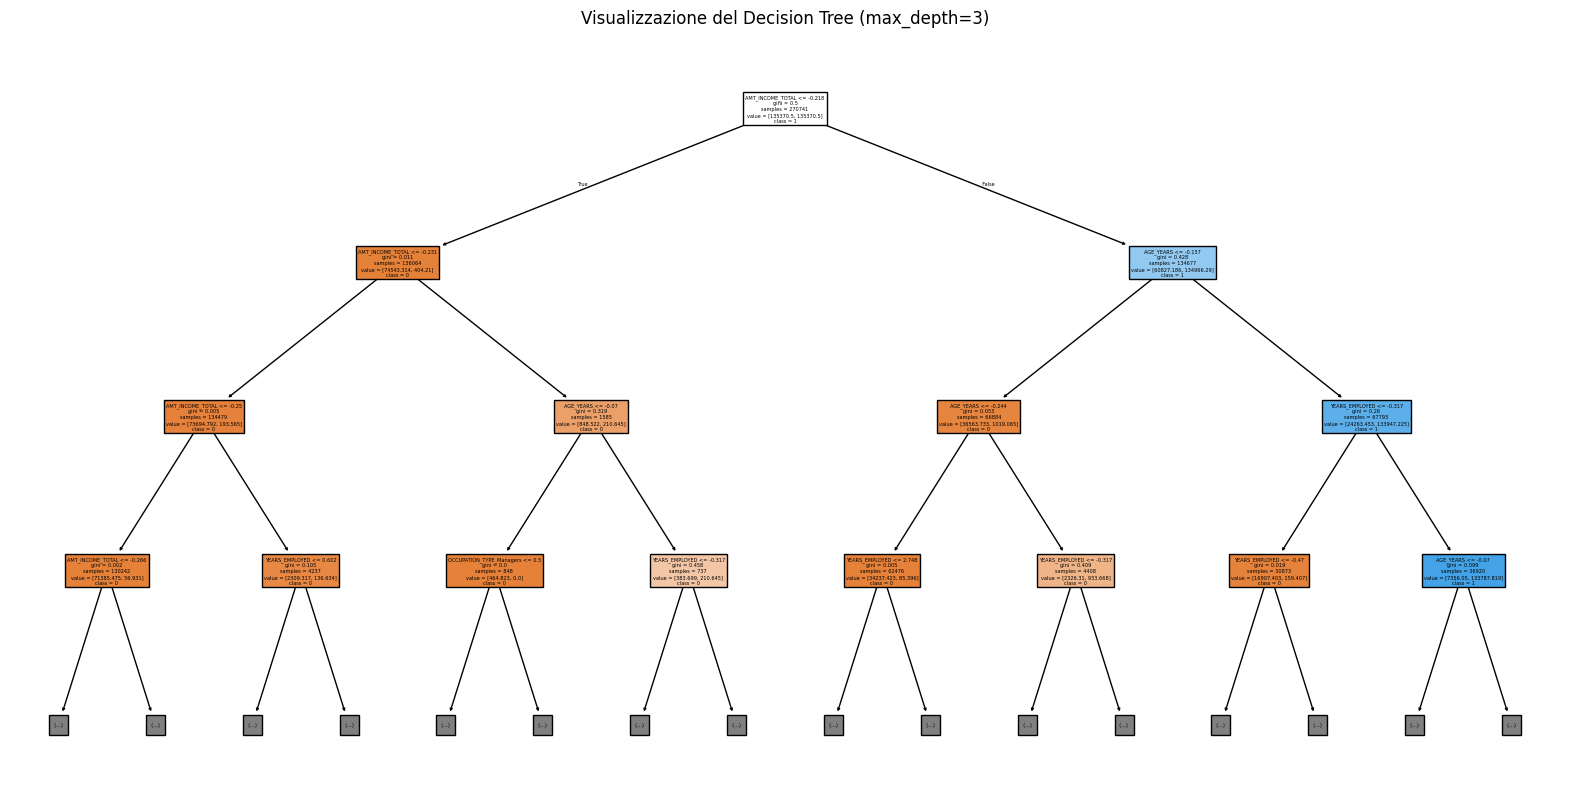

In [14]:
# Sezione 6: Scelta e uso del miglior modello
print("\n--- Inizio Scelta e Uso del Miglior Modello ---")
# Raccogliere le metriche di tutti i modelli per un confronto finale
metrics_all = {
    'Regressione Logistica': {
        'Accuracy': accuracy_lr, 'Precision': precision_lr, 'Recall': recall_lr, 'F1-Score': f1_lr, 'ROC AUC': roc_auc_lr
    },
    'Decision Tree': {
        'Accuracy': accuracy_dt, 'Precision': precision_dt, 'Recall': recall_dt, 'F1-Score': f1_dt, 'ROC AUC': roc_auc_dt
    },
    'Random Forest (Migliore)': {
        'Accuracy': accuracy_score(y_test, y_pred_best_rf), 'Precision': precision_score(y_test, y_pred_best_rf), 'Recall': recall_score(y_test, y_pred_best_rf), 'F1-Score': best_f1_rf, 'ROC AUC': best_roc_auc_rf
    },
    'Bagging LR (Migliore)': {
        'Accuracy': accuracy_score(y_test, best_bagging_lr_model.predict(X_test)), 'Precision': precision_score(y_test, best_bagging_lr_model.predict(X_test)), 'Recall': recall_score(y_test, best_bagging_lr_model.predict(X_test)), 'F1-Score': best_f1_bagging_lr, 'ROC AUC': best_roc_auc_bagging_lr
    },
    'Bagging DT (Migliore)': {
        'Accuracy': accuracy_score(y_test, best_bagging_dt_model.predict(X_test)), 'Precision': precision_score(y_test, best_bagging_dt_model.predict(X_test)), 'Recall': recall_score(y_test, best_bagging_dt_model.predict(X_test)), 'F1-Score': best_f1_bagging_dt, 'ROC AUC': best_roc_auc_bagging_dt
    }
}
metrics_df_final = pd.DataFrame(metrics_all).T
print("\nConfronto delle Metriche di Performance di tutti i Modelli:")
print(metrics_df_final.round(4))

# Il modello Random Forest (Migliore) è stato selezionato per le sue performance superiori.
print("\nIl modello Random Forest (Migliore) è stato scelto come il più adatto per le sue prestazioni predittive superiori in termini di F1-Score e ROC AUC.")

# Visualizzazione di un singolo albero del Decision Tree (per interpretabilità)
plt.figure(figsize=(20, 10))
plot_tree(dt_model, filled=True, max_depth=3, feature_names=X_train.columns.tolist(), class_names=['0', '1'])
plt.title('Visualizzazione del Decision Tree (max_depth=3)')
plt.show()

# Sezione 7: Conclusioni
### Riepilogo Analisi e Scelta del Modello

L'analisi ha confrontato diversi modelli. Il modello **Random Forest** è risultato il più efficace.

#### Interpretabilità:
Le feature più influenti sono `AMT_INCOME_TOTAL`, `AGE_YEARS`, `YEARS_EMPLOYED`e tramite il diagramma tree del modello selezionato possiamo capire il perché è stata respinta la richiesta di carta di credito dall'impresa creditiza.